In [1]:
import hhgen.plots as plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.externals import joblib

In [2]:
features = ['hh_m','hh_pt', 'hh_eta','hgg_pt_hh_m','hbb_pt_hh_m','cos_theta_cs','cos_theta_hbb','cos_theta_hgg']
features+=['leadJet_pt','leadJet_eta','subleadJet_pt','subleadJet_eta']
features+=['leadPho_pt','leadPho_eta','subleadPho_pt','subleadPho_eta']

scaler=RobustScaler()

In [3]:
df=pd.read_hdf("node_SM.hd5")
df=df[df.cat>0]
df.weight/=df.weight.mean()

X = df[features]
y = df['cat'] 
w = df['weight']

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2, random_state=12351)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

clf=joblib.load('clf_accuSM9.joblib')
rw=np.loadtxt("rw_accuSM9.txt")

In [4]:
#reset indices
X_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
w_test.reset_index(drop=True,inplace=True)

Weighted least squares for true/pred plot:  213.381
Spread for truth/pred plot:  1.37776


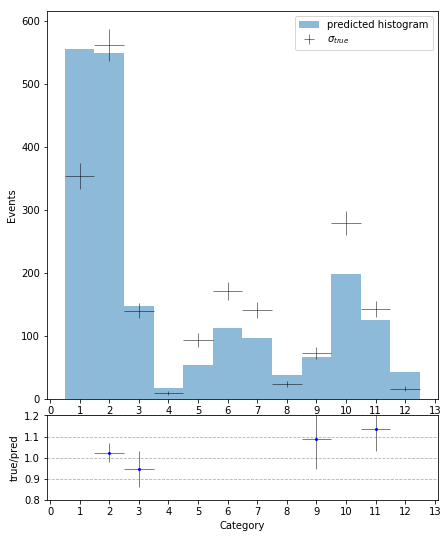

In [5]:
#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)

y_pred_weight=np.multiply(y_pred_prob,w_test.reshape(-1,1))
y_pred= np.arange(1,13).reshape(1,-1)*np.ones_like(y_pred_weight)

plots.plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

In [6]:
#scaling data back
X_test=pd.DataFrame(scaler.inverse_transform(X_test))

In [7]:
y_pred_weight=pd.DataFrame(y_pred_weight)

frames=[X_test,y_test,w_test]
df = pd.concat(frames,axis=1,ignore_index=True)

df.columns=['hh_m','hh_pt', 'hh_eta','hgg_pt_hh_m','hbb_pt_hh_m','cos_theta_cs','cos_theta_hbb','cos_theta_hgg',
            'leadJet_pt','leadJet_eta','subleadJet_pt','subleadJet_eta','leadPho_pt','leadPho_eta',
            'subleadPho_pt','subleadPho_eta','cat_true','w_true']

Total number of event in pred hist:  537.607
Total number of event in true hist:  341.177


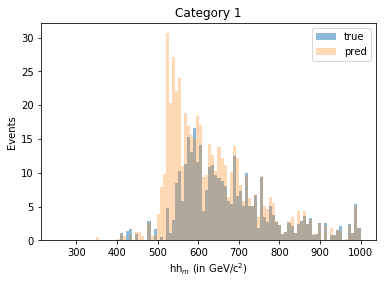

Total number of event in pred hist:  549.013
Total number of event in true hist:  561.792


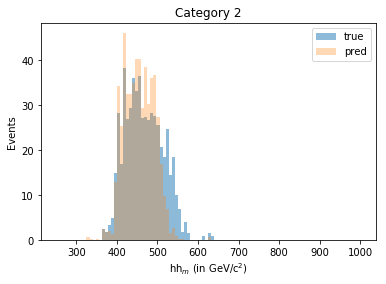

Total number of event in pred hist:  147.682
Total number of event in true hist:  139.795


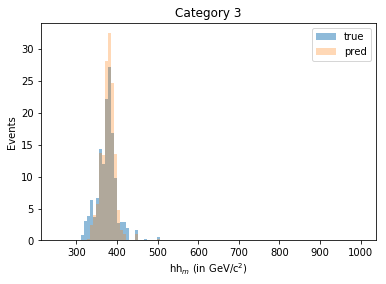

Total number of event in pred hist:  16.029
Total number of event in true hist:  8.84508


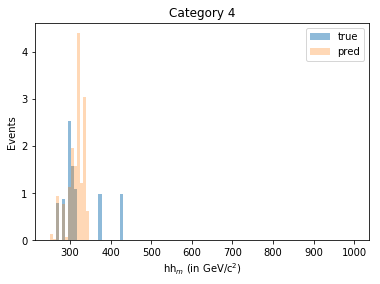

Total number of event in pred hist:  50.388
Total number of event in true hist:  87.6549


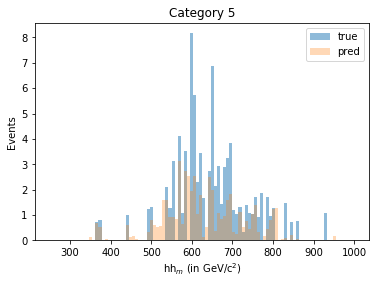

Total number of event in pred hist:  112.823
Total number of event in true hist:  170.412


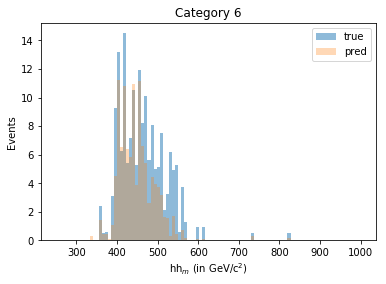

Total number of event in pred hist:  96.9151
Total number of event in true hist:  140.462


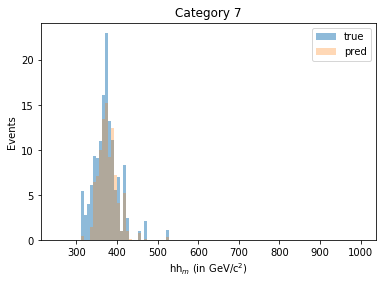

Total number of event in pred hist:  37.6214
Total number of event in true hist:  23.1405


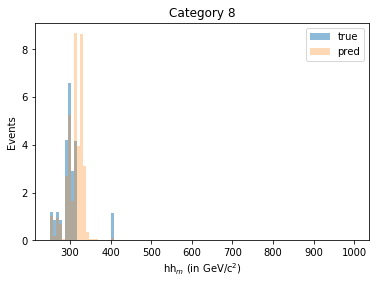

Total number of event in pred hist:  63.0119
Total number of event in true hist:  67.9452


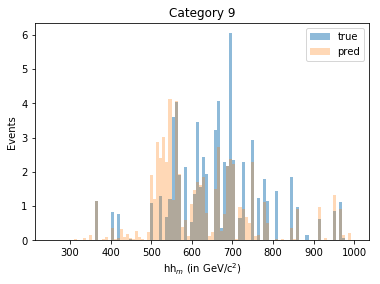

Total number of event in pred hist:  198.282
Total number of event in true hist:  277.967


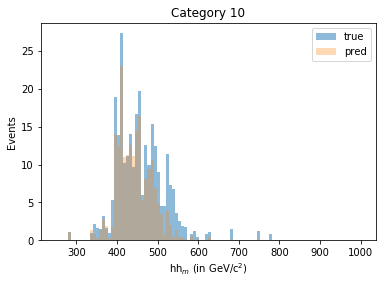

Total number of event in pred hist:  125.065
Total number of event in true hist:  141.759


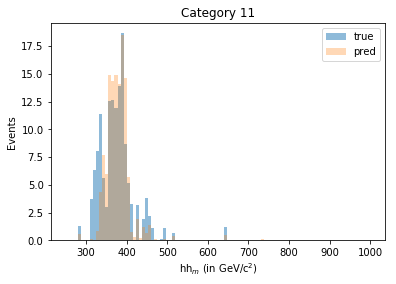

Total number of event in pred hist:  42.421
Total number of event in true hist:  15.9082


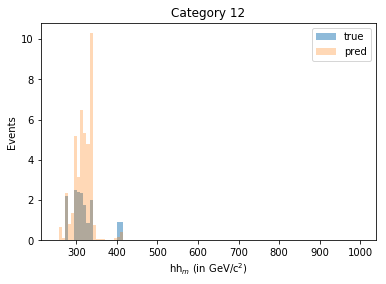

In [8]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(cat_true['hh_m'],weights=cat_true.w_true,range=[250,1000],bins=100,alpha=0.5,label='true')
    plt.hist(df['hh_m'].ravel(),weights=y_pred_weight[i].ravel(),range=[250,1000],bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(cat_true['hh_m'],weights=cat_true.w_true,range=[250,1000],bins=100)
    h_pred=np.histogram(df['hh_m'].ravel(),weights=y_pred_weight[i].ravel(),range=[250,1000],bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("hh$_m$ (in GeV/c$^2$)")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()

Total number of event in pred hist:  94.8573
Total number of event in true hist:  64.0923


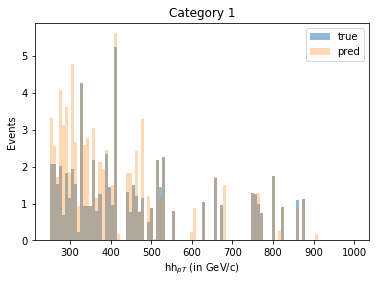

Total number of event in pred hist:  109.433
Total number of event in true hist:  121.578


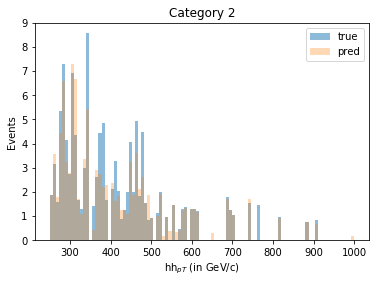

Total number of event in pred hist:  27.6516
Total number of event in true hist:  24.5801


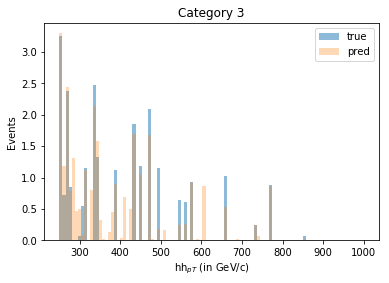

Total number of event in pred hist:  3.96982
Total number of event in true hist:  0.748707


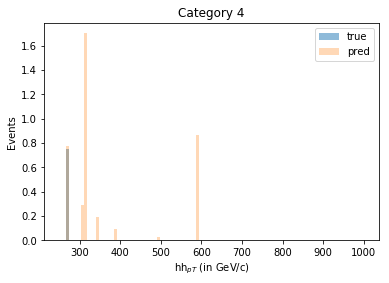

Total number of event in pred hist:  8.73795
Total number of event in true hist:  11.1605


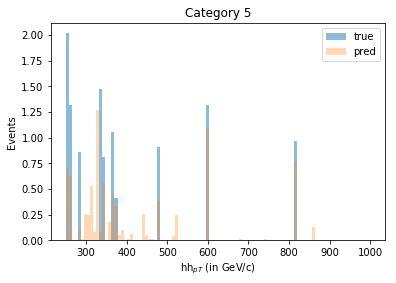

Total number of event in pred hist:  20.9756
Total number of event in true hist:  27.7734


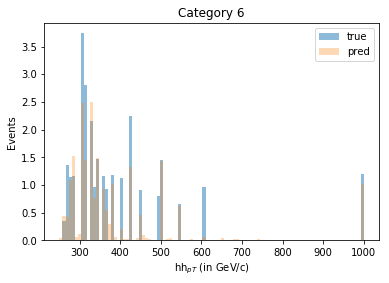

Total number of event in pred hist:  10.7806
Total number of event in true hist:  18.4648


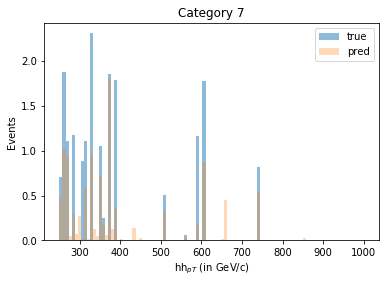

Total number of event in pred hist:  2.11253
Total number of event in true hist:  0.722471


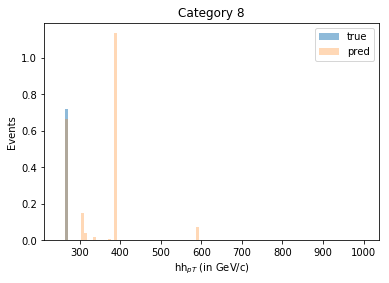

Total number of event in pred hist:  8.82626
Total number of event in true hist:  8.52813


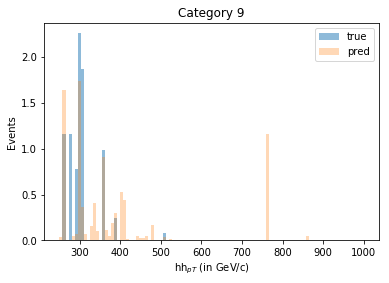

Total number of event in pred hist:  14.8386
Total number of event in true hist:  21.6558


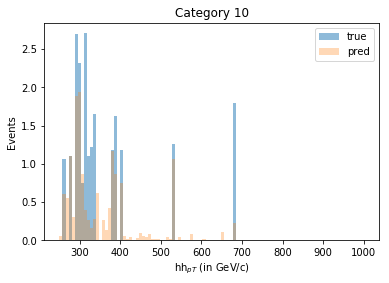

Total number of event in pred hist:  4.5254
Total number of event in true hist:  6.45755


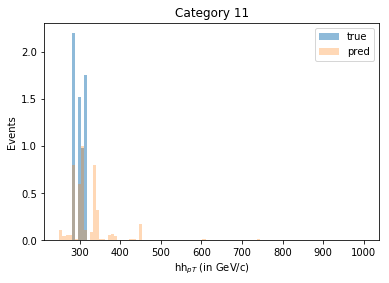

Total number of event in pred hist:  1.33631
Total number of event in true hist:  2.2834


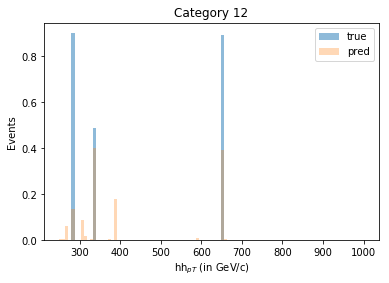

In [9]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(cat_true['hh_pt'].ravel(),weights=cat_true.w_true.ravel(),range=[250,1000],bins=100,alpha=0.5,label='true')
    plt.hist(df['hh_pt'].ravel(),weights=y_pred_weight[i].ravel(),range=[250,1000],bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(cat_true['hh_pt'],weights=cat_true.w_true,range=[250,1000],bins=100)
    h_pred=np.histogram(df['hh_pt'].ravel(),weights=y_pred_weight[i].ravel(),range=[250,1000],bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("hh$_{pT}$ (in GeV/c)")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()

Total number of event in pred hist:  554.925
Total number of event in true hist:  353.729


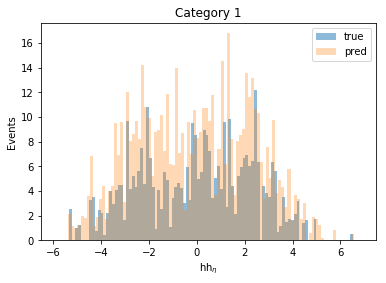

Total number of event in pred hist:  549.023
Total number of event in true hist:  561.792


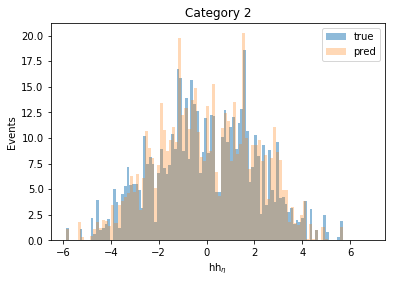

Total number of event in pred hist:  147.683
Total number of event in true hist:  139.795


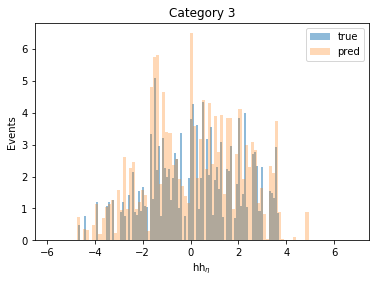

Total number of event in pred hist:  16.0291
Total number of event in true hist:  8.84508


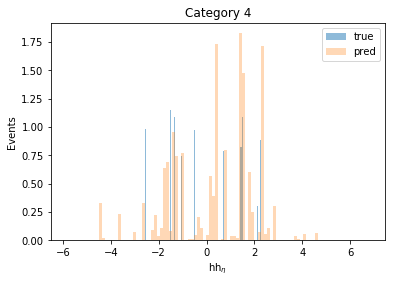

Total number of event in pred hist:  52.8673
Total number of event in true hist:  92.6523


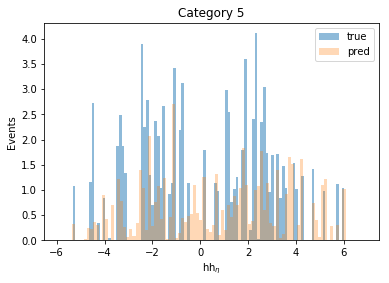

Total number of event in pred hist:  112.882
Total number of event in true hist:  170.412


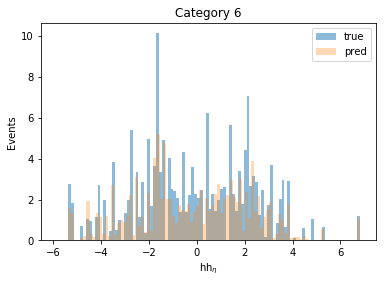

Total number of event in pred hist:  96.9153
Total number of event in true hist:  140.462


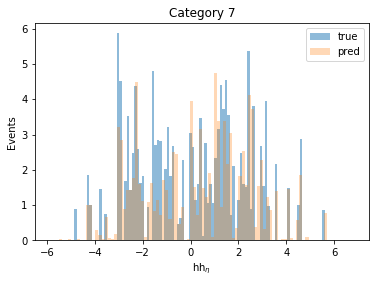

Total number of event in pred hist:  37.6227
Total number of event in true hist:  23.1405


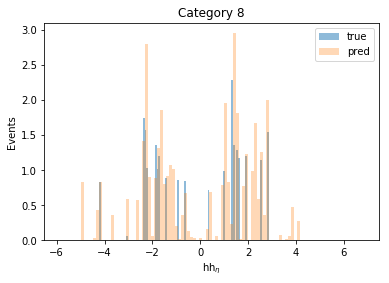

Total number of event in pred hist:  66.1466
Total number of event in true hist:  72.1242


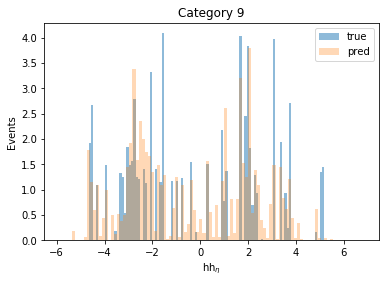

Total number of event in pred hist:  198.308
Total number of event in true hist:  279.271


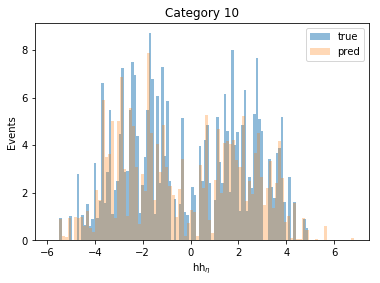

Total number of event in pred hist:  125.067
Total number of event in true hist:  141.759


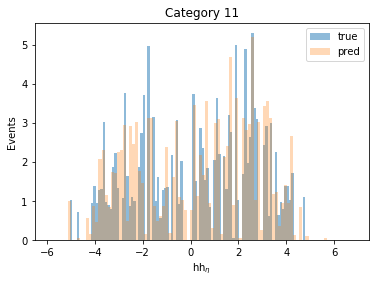

Total number of event in pred hist:  42.4211
Total number of event in true hist:  15.9082


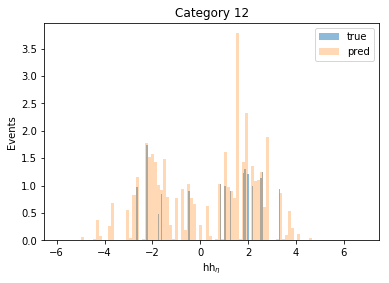

In [10]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(cat_true['hh_eta'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(df['hh_eta'].ravel(),weights=y_pred_weight[i].ravel(),bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(cat_true['hh_eta'],weights=cat_true.w_true,bins=100)
    h_pred=np.histogram(df['hh_eta'].ravel(),weights=y_pred_weight[i].ravel(),bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("hh$_{\eta}$")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()

Total number of event in pred hist:  554.925
Total number of event in true hist:  353.729


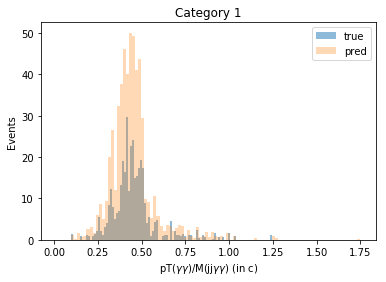

Total number of event in pred hist:  549.023
Total number of event in true hist:  561.792


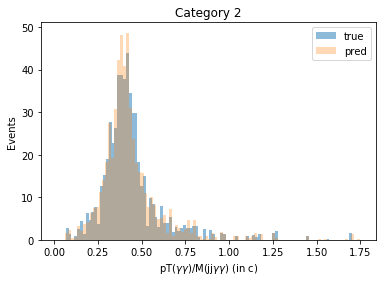

Total number of event in pred hist:  147.683
Total number of event in true hist:  139.795


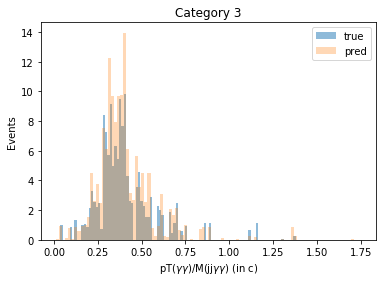

Total number of event in pred hist:  16.0291
Total number of event in true hist:  8.84508


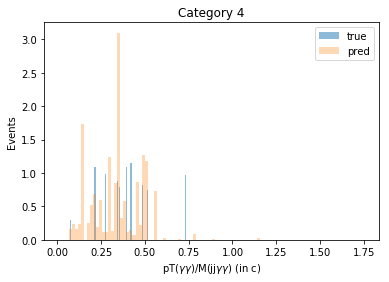

Total number of event in pred hist:  52.8673
Total number of event in true hist:  92.6523


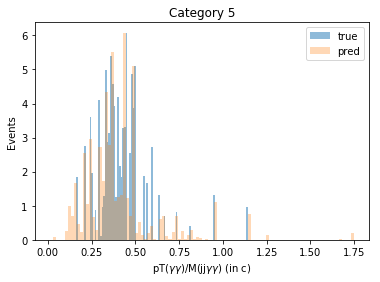

Total number of event in pred hist:  112.882
Total number of event in true hist:  170.412


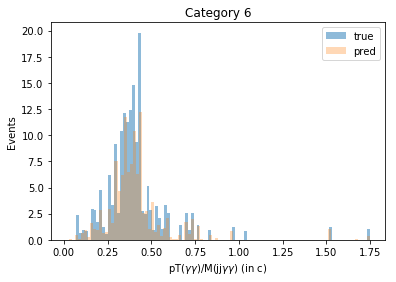

Total number of event in pred hist:  96.9153
Total number of event in true hist:  140.462


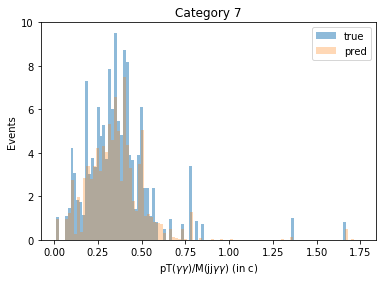

Total number of event in pred hist:  37.6227
Total number of event in true hist:  23.1405


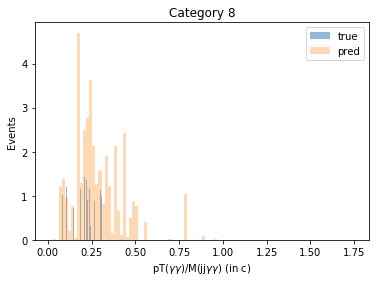

Total number of event in pred hist:  66.1466
Total number of event in true hist:  72.1242


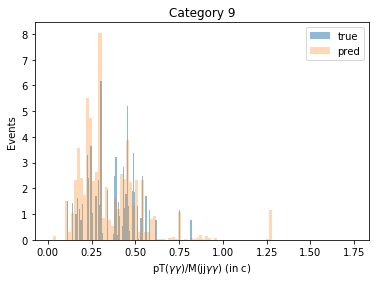

Total number of event in pred hist:  198.308
Total number of event in true hist:  279.271


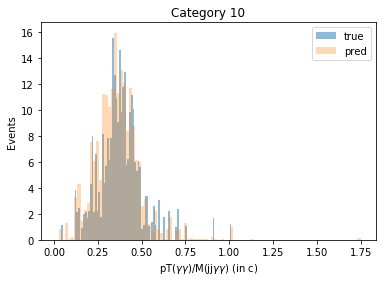

Total number of event in pred hist:  125.067
Total number of event in true hist:  141.759


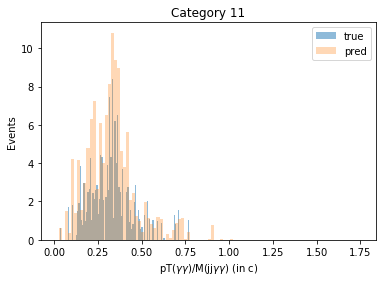

Total number of event in pred hist:  42.4211
Total number of event in true hist:  15.9082


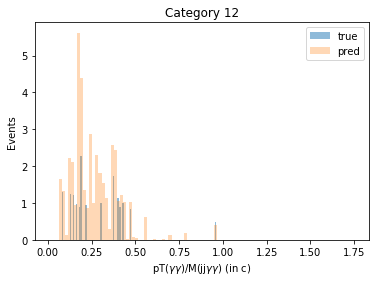

In [11]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(cat_true['hgg_pt_hh_m'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(df['hgg_pt_hh_m'].ravel(),weights=y_pred_weight[i].ravel(),bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(cat_true['hgg_pt_hh_m'],weights=cat_true.w_true,bins=100)
    h_pred=np.histogram(df['hgg_pt_hh_m'].ravel(),weights=y_pred_weight[i].ravel(),bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("pT($\gamma\gamma$)/M(jj$\gamma\gamma$) (in c)")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()

Total number of event in pred hist:  554.925
Total number of event in true hist:  353.729


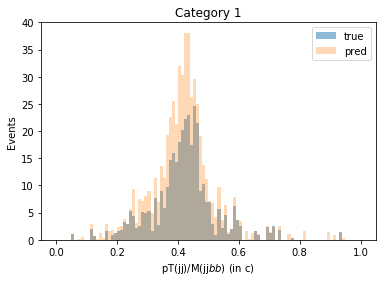

Total number of event in pred hist:  549.023
Total number of event in true hist:  561.792


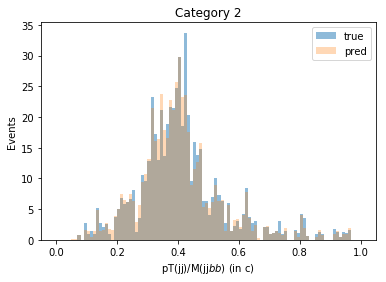

Total number of event in pred hist:  147.683
Total number of event in true hist:  139.795


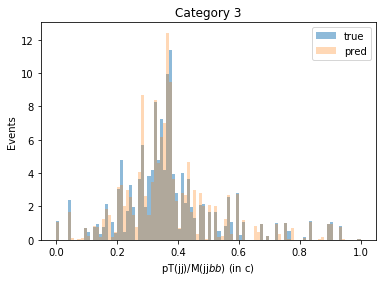

Total number of event in pred hist:  16.0291
Total number of event in true hist:  8.84508


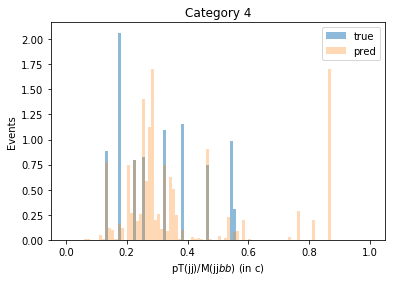

Total number of event in pred hist:  52.8673
Total number of event in true hist:  92.6523


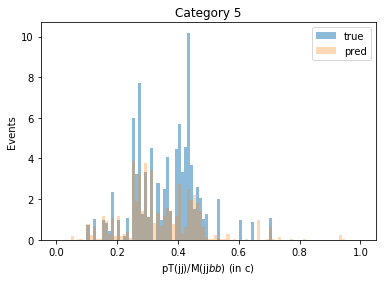

Total number of event in pred hist:  112.882
Total number of event in true hist:  170.412


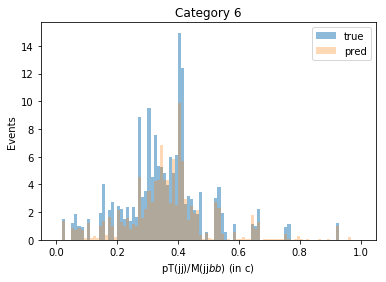

Total number of event in pred hist:  96.9153
Total number of event in true hist:  140.462


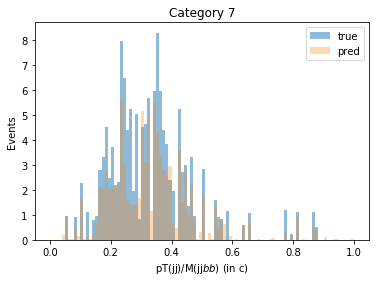

Total number of event in pred hist:  37.6227
Total number of event in true hist:  23.1405


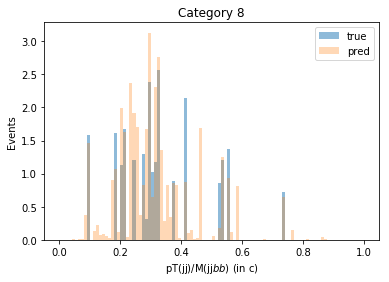

Total number of event in pred hist:  66.1466
Total number of event in true hist:  72.1242


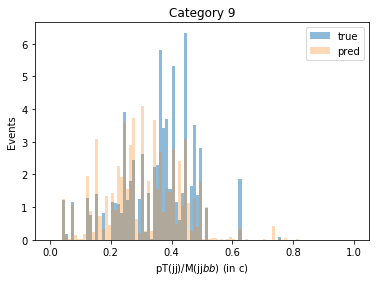

Total number of event in pred hist:  198.308
Total number of event in true hist:  279.271


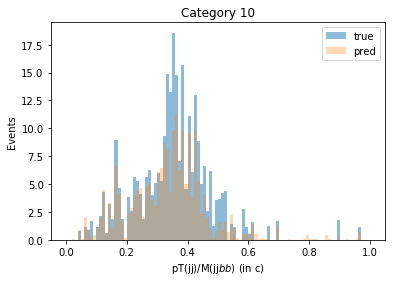

Total number of event in pred hist:  125.067
Total number of event in true hist:  141.759


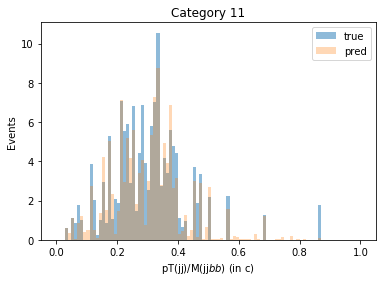

Total number of event in pred hist:  42.4211
Total number of event in true hist:  15.9082


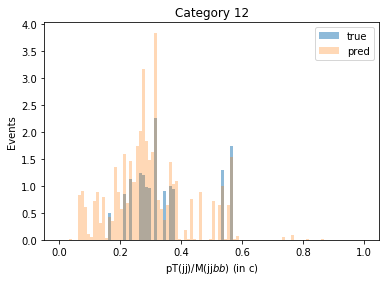

In [12]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(cat_true['hbb_pt_hh_m'].ravel(),range=[0,1],weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(df['hbb_pt_hh_m'].ravel(),range=[0,1],weights=y_pred_weight[i].ravel(),bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(cat_true['hbb_pt_hh_m'],weights=cat_true.w_true,bins=100)
    h_pred=np.histogram(df['hbb_pt_hh_m'].ravel(),weights=y_pred_weight[i].ravel(),bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("pT(jj)/M(jj$bb$) (in c)")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()

Total number of event in pred hist:  554.925
Total number of event in true hist:  353.729


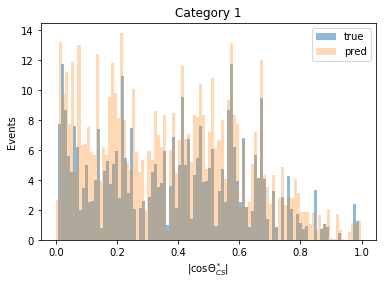

Total number of event in pred hist:  549.023
Total number of event in true hist:  561.792


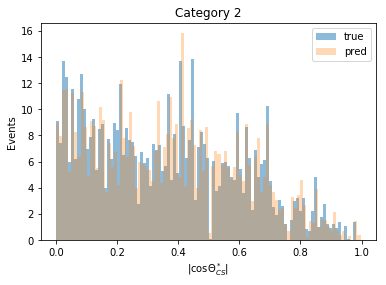

Total number of event in pred hist:  147.683
Total number of event in true hist:  139.795


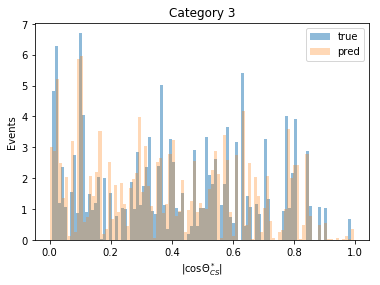

Total number of event in pred hist:  16.0291
Total number of event in true hist:  8.84508


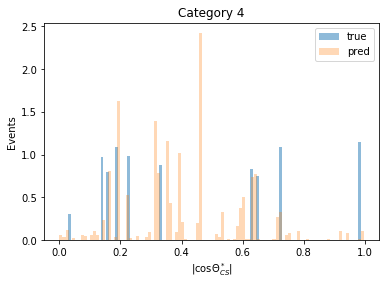

Total number of event in pred hist:  52.8673
Total number of event in true hist:  92.6523


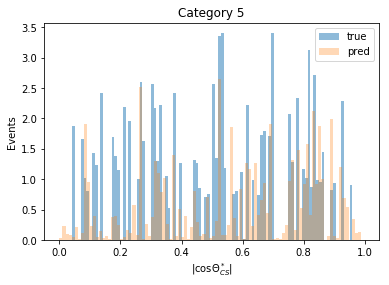

Total number of event in pred hist:  112.882
Total number of event in true hist:  170.412


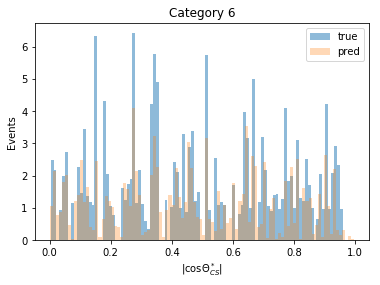

Total number of event in pred hist:  96.9153
Total number of event in true hist:  140.462


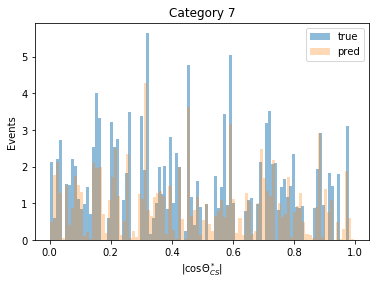

Total number of event in pred hist:  37.6227
Total number of event in true hist:  23.1405


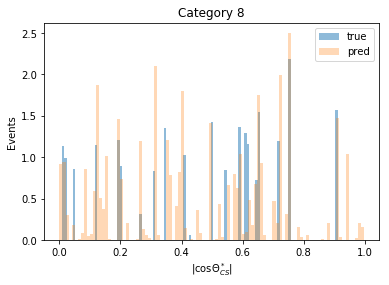

Total number of event in pred hist:  66.1466
Total number of event in true hist:  72.1242


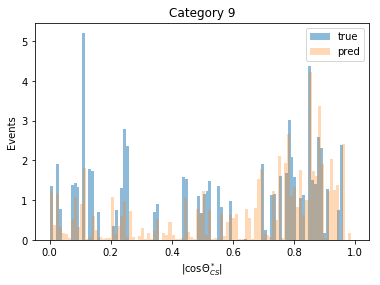

Total number of event in pred hist:  198.308
Total number of event in true hist:  279.271


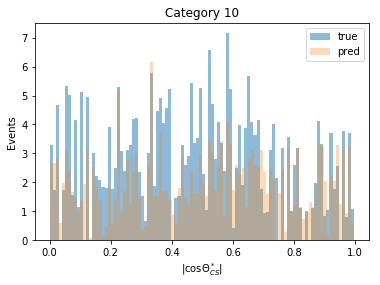

Total number of event in pred hist:  125.067
Total number of event in true hist:  141.759


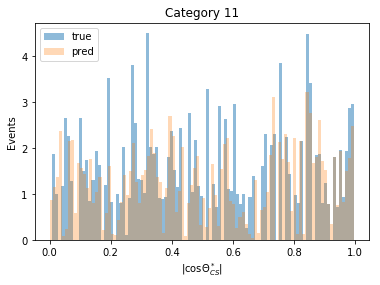

Total number of event in pred hist:  42.4211
Total number of event in true hist:  15.9082


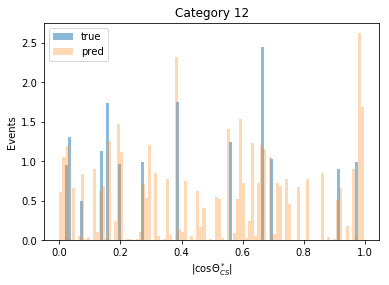

In [13]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(np.abs(cat_true['cos_theta_cs'].ravel()),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(np.abs(df['cos_theta_cs'].ravel()),weights=y_pred_weight[i].ravel(),bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(np.abs(cat_true['cos_theta_cs'].ravel()),weights=cat_true.w_true,bins=100)
    h_pred=np.histogram(np.abs(df['cos_theta_cs'].ravel()),weights=y_pred_weight[i].ravel(),bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("|cos$\Theta_{CS}^*$|")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()

Total number of event in pred hist:  554.925
Total number of event in true hist:  353.729


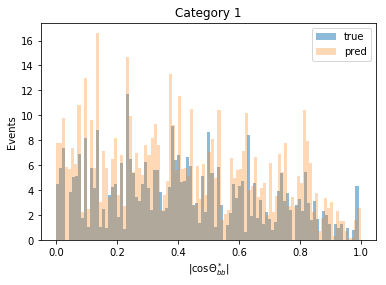

Total number of event in pred hist:  549.023
Total number of event in true hist:  561.792


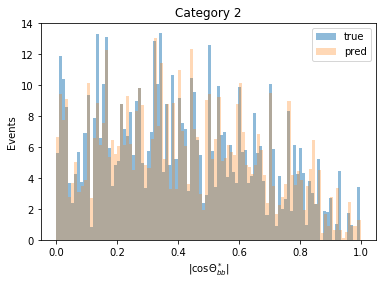

Total number of event in pred hist:  147.683
Total number of event in true hist:  139.795


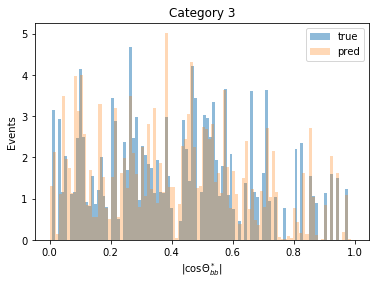

Total number of event in pred hist:  16.0291
Total number of event in true hist:  8.84508


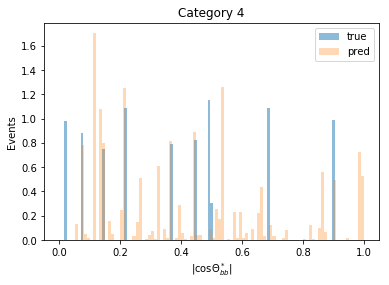

Total number of event in pred hist:  52.8673
Total number of event in true hist:  92.6523


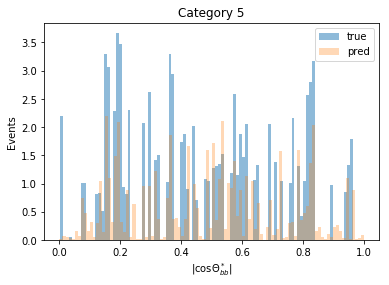

Total number of event in pred hist:  112.882
Total number of event in true hist:  170.412


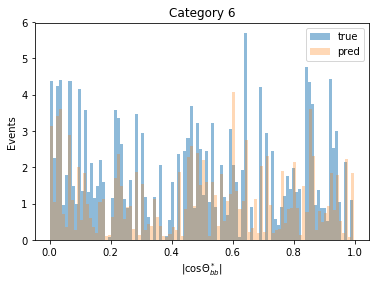

Total number of event in pred hist:  96.9153
Total number of event in true hist:  140.462


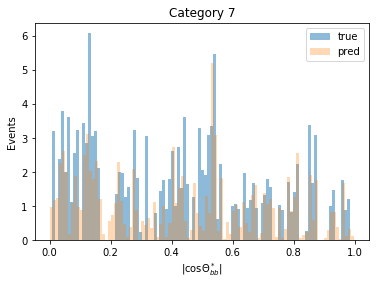

Total number of event in pred hist:  37.6227
Total number of event in true hist:  23.1405


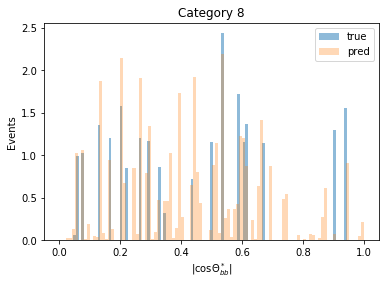

Total number of event in pred hist:  66.1466
Total number of event in true hist:  72.1242


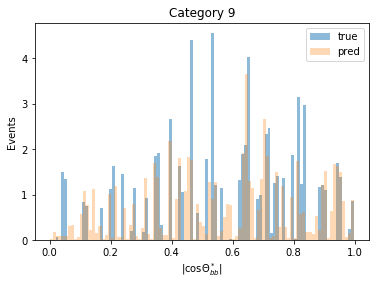

Total number of event in pred hist:  198.309
Total number of event in true hist:  279.271


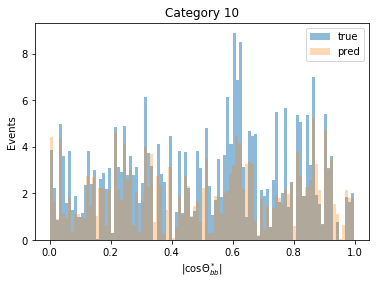

Total number of event in pred hist:  125.067
Total number of event in true hist:  141.759


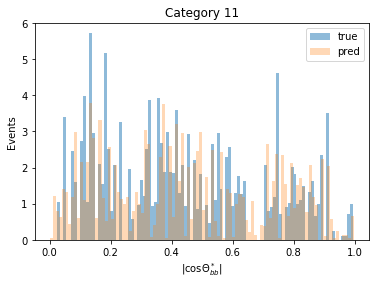

Total number of event in pred hist:  42.4211
Total number of event in true hist:  15.9082


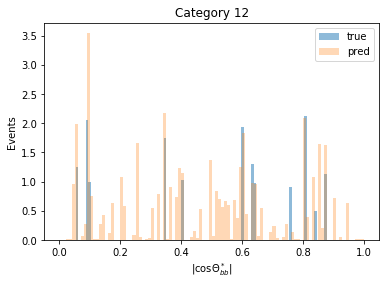

In [14]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(np.abs(cat_true['cos_theta_hbb'].ravel()),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(np.abs(df['cos_theta_hbb'].ravel()),weights=y_pred_weight[i].ravel(),bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(np.abs(cat_true['cos_theta_hbb'].ravel()),weights=cat_true.w_true,bins=100)
    h_pred=np.histogram(np.abs(df['cos_theta_hbb'].ravel()),weights=y_pred_weight[i].ravel(),bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("|cos$\Theta_{bb}^*$|")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()

Total number of event in pred hist:  554.924
Total number of event in true hist:  353.729


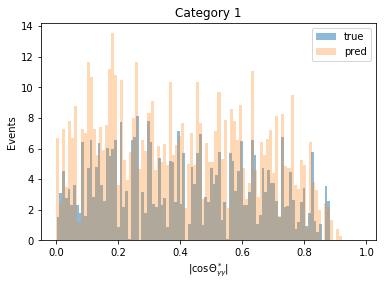

Total number of event in pred hist:  549.023
Total number of event in true hist:  561.792


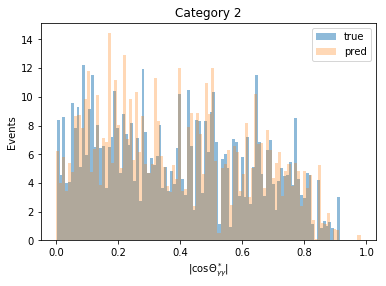

Total number of event in pred hist:  147.683
Total number of event in true hist:  139.795


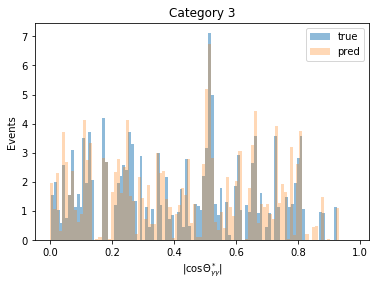

Total number of event in pred hist:  16.0291
Total number of event in true hist:  8.84509


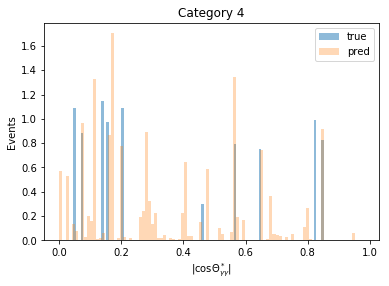

Total number of event in pred hist:  52.8673
Total number of event in true hist:  92.6523


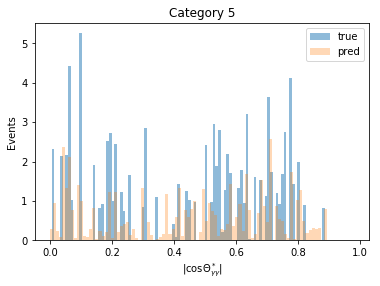

Total number of event in pred hist:  112.882
Total number of event in true hist:  170.412


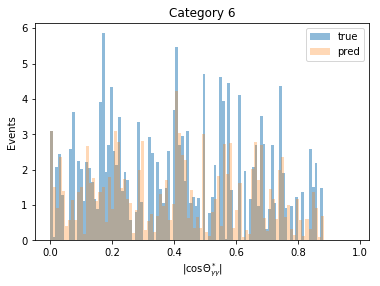

Total number of event in pred hist:  96.9153
Total number of event in true hist:  140.462


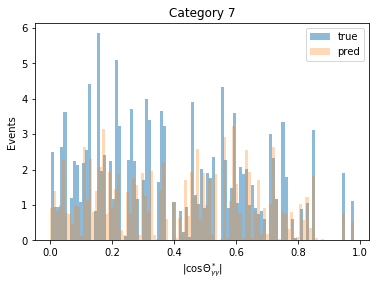

Total number of event in pred hist:  37.6227
Total number of event in true hist:  23.1405


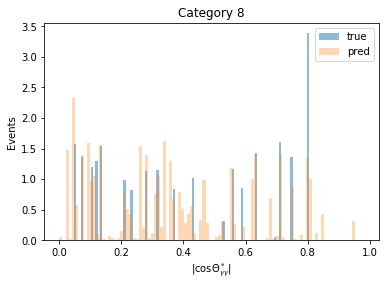

Total number of event in pred hist:  66.1466
Total number of event in true hist:  72.1242


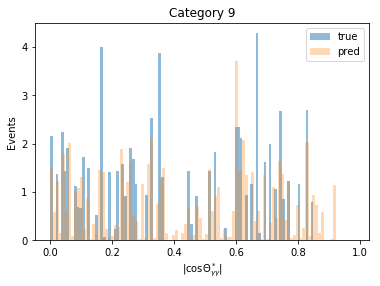

Total number of event in pred hist:  198.308
Total number of event in true hist:  279.271


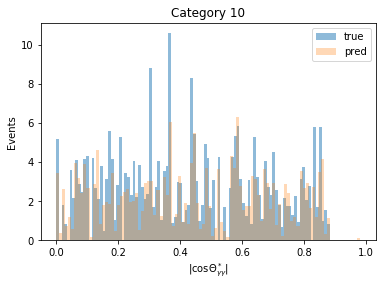

Total number of event in pred hist:  125.067
Total number of event in true hist:  141.759


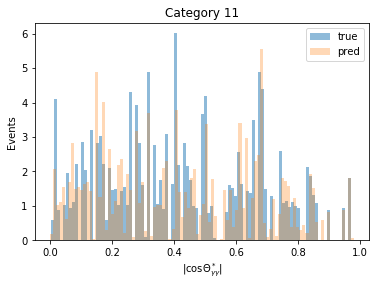

Total number of event in pred hist:  42.4211
Total number of event in true hist:  15.9082


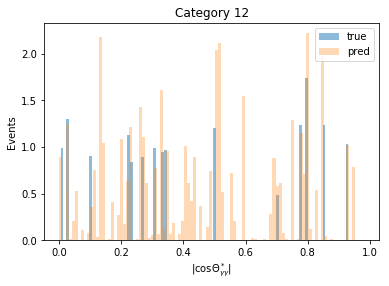

In [15]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(np.abs(cat_true['cos_theta_hgg'].ravel()),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(np.abs(df['cos_theta_hgg'].ravel()),weights=y_pred_weight[i].ravel(),bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(np.abs(cat_true['cos_theta_hgg'].ravel()),weights=cat_true.w_true,bins=100)
    h_pred=np.histogram(np.abs(df['cos_theta_hgg'].ravel()),weights=y_pred_weight[i].ravel(),bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("|cos$\Theta_{\gamma\gamma}^*$|")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()

Total number of event in pred hist:  554.925
Total number of event in true hist:  353.729


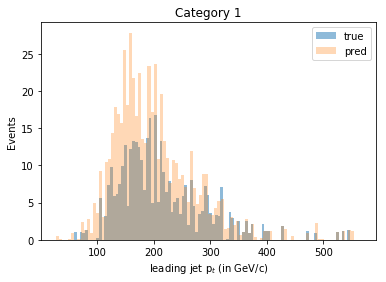

Total number of event in pred hist:  549.023
Total number of event in true hist:  561.792


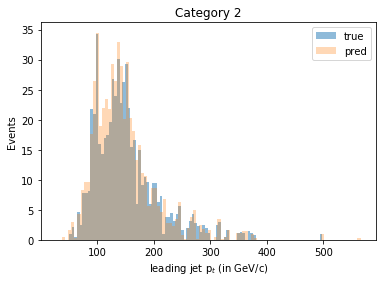

Total number of event in pred hist:  147.683
Total number of event in true hist:  139.795


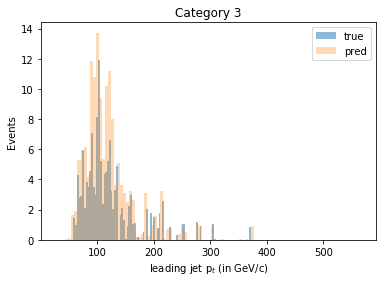

Total number of event in pred hist:  16.0291
Total number of event in true hist:  8.84508


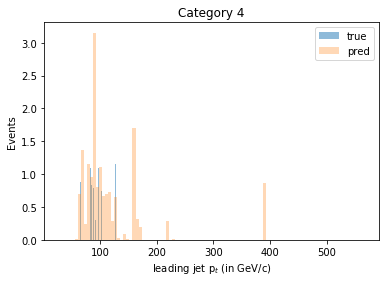

Total number of event in pred hist:  52.8673
Total number of event in true hist:  92.6523


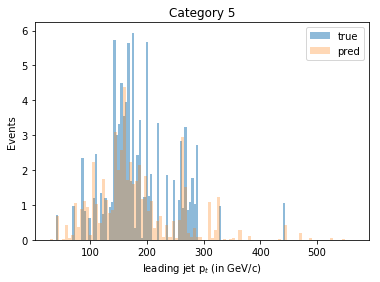

Total number of event in pred hist:  112.882
Total number of event in true hist:  170.412


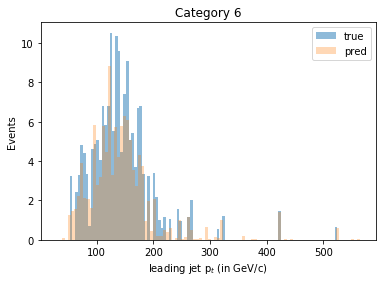

Total number of event in pred hist:  96.9153
Total number of event in true hist:  140.462


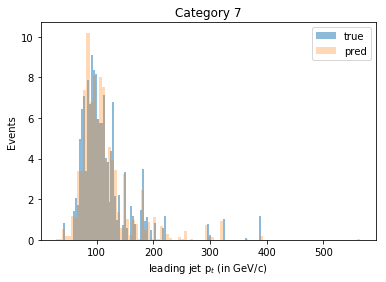

Total number of event in pred hist:  37.6227
Total number of event in true hist:  23.1405


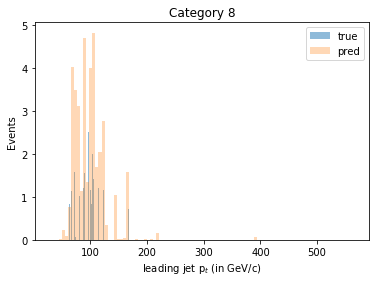

Total number of event in pred hist:  66.1466
Total number of event in true hist:  72.1242


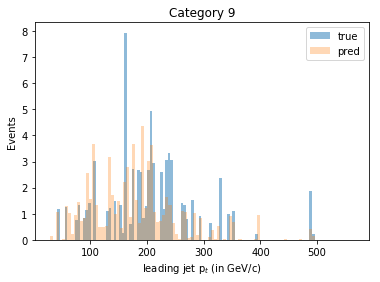

Total number of event in pred hist:  198.308
Total number of event in true hist:  279.271


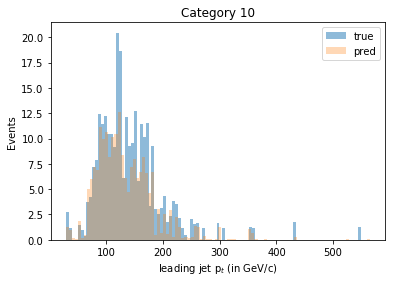

Total number of event in pred hist:  125.067
Total number of event in true hist:  141.759


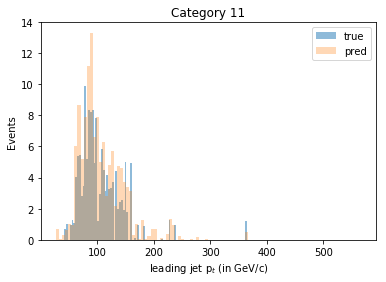

Total number of event in pred hist:  42.4211
Total number of event in true hist:  15.9082


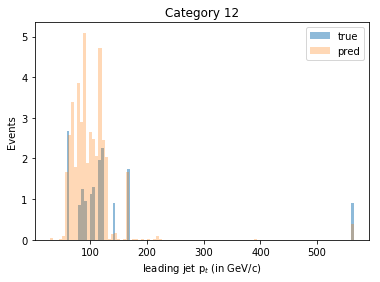

In [16]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(cat_true['leadJet_pt'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(df['leadJet_pt'].ravel(),weights=y_pred_weight[i].ravel(),bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(cat_true['leadJet_pt'].ravel(),weights=cat_true.w_true,bins=100)
    h_pred=np.histogram(df['leadJet_pt'].ravel(),weights=y_pred_weight[i].ravel(),bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("leading jet p$_t$ (in GeV/c)")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()

Total number of event in pred hist:  554.925
Total number of event in true hist:  353.729


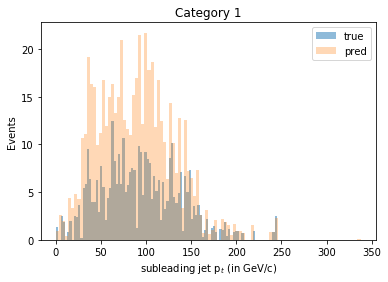

Total number of event in pred hist:  549.023
Total number of event in true hist:  561.792


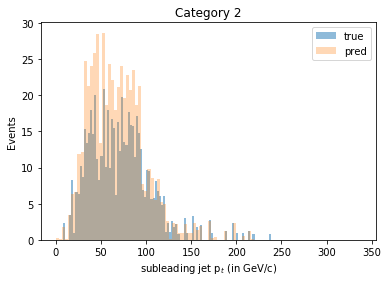

Total number of event in pred hist:  147.683
Total number of event in true hist:  139.795


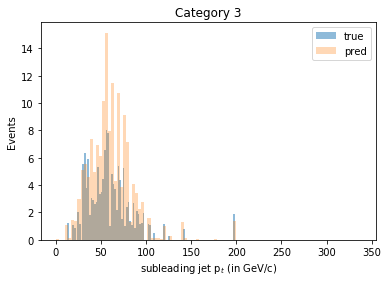

Total number of event in pred hist:  16.0291
Total number of event in true hist:  8.84508


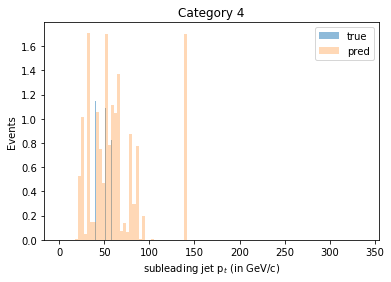

Total number of event in pred hist:  52.8673
Total number of event in true hist:  92.6523


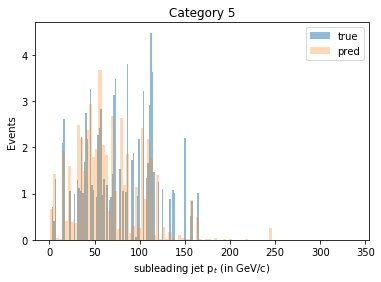

Total number of event in pred hist:  112.882
Total number of event in true hist:  170.412


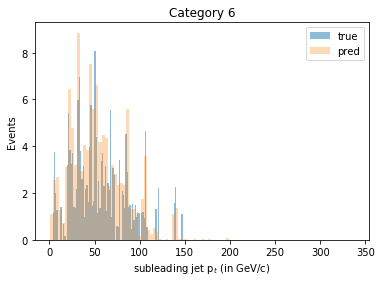

Total number of event in pred hist:  96.9153
Total number of event in true hist:  140.462


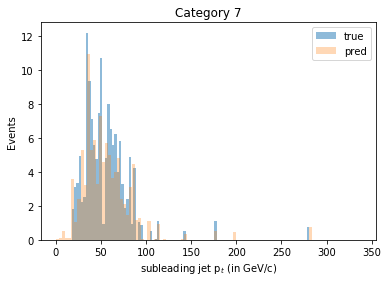

Total number of event in pred hist:  37.6227
Total number of event in true hist:  23.1405


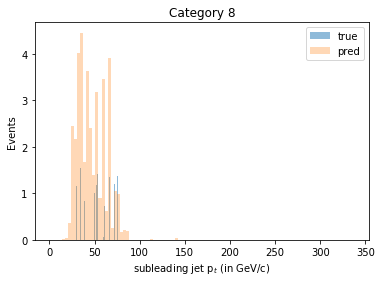

Total number of event in pred hist:  66.1466
Total number of event in true hist:  72.1242


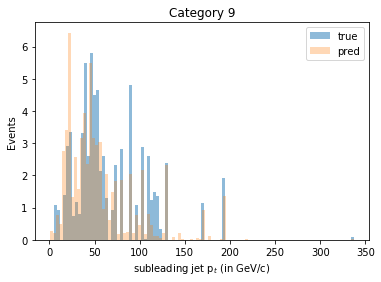

Total number of event in pred hist:  198.308
Total number of event in true hist:  279.271


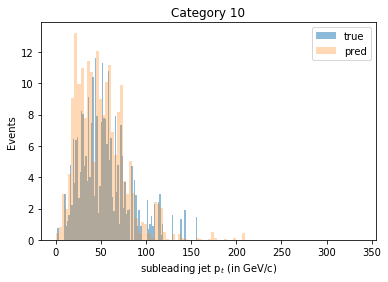

Total number of event in pred hist:  125.067
Total number of event in true hist:  141.759


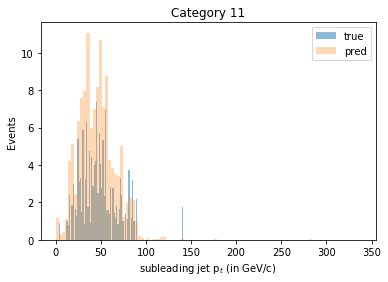

Total number of event in pred hist:  42.4211
Total number of event in true hist:  15.9082


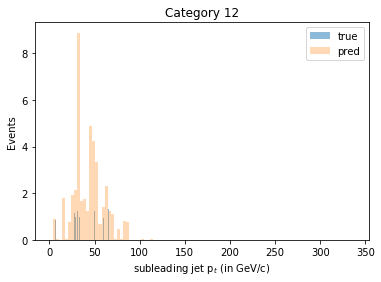

In [17]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(cat_true['subleadJet_pt'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(df['subleadJet_pt'].ravel(),weights=y_pred_weight[i].ravel(),bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(cat_true['subleadJet_pt'].ravel(),weights=cat_true.w_true,bins=100)
    h_pred=np.histogram(df['subleadJet_pt'].ravel(),weights=y_pred_weight[i].ravel(),bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("subleading jet p$_t$ (in GeV/c)")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()

Total number of event in pred hist:  554.925
Total number of event in true hist:  353.729


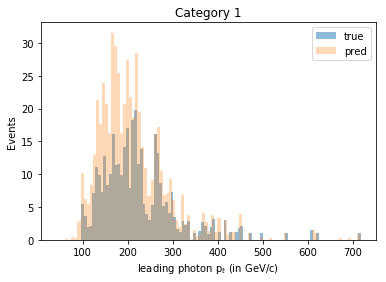

Total number of event in pred hist:  549.023
Total number of event in true hist:  561.792


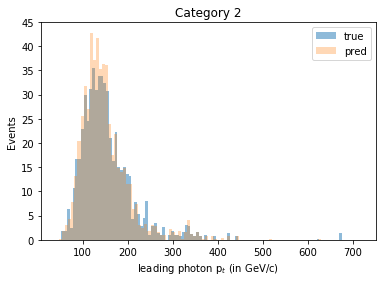

Total number of event in pred hist:  147.683
Total number of event in true hist:  139.795


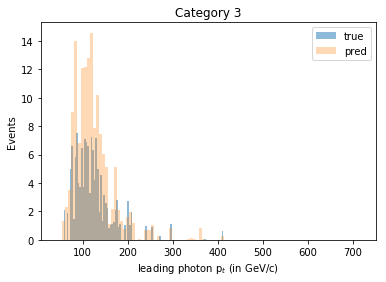

Total number of event in pred hist:  16.0291
Total number of event in true hist:  8.84508


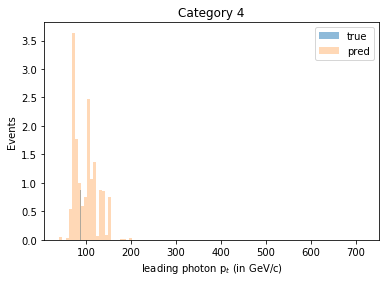

Total number of event in pred hist:  52.8673
Total number of event in true hist:  92.6523


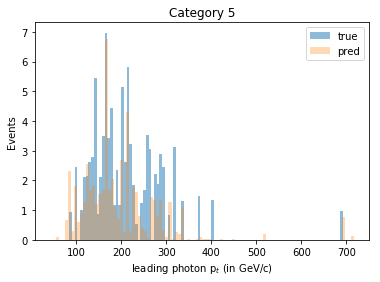

Total number of event in pred hist:  112.882
Total number of event in true hist:  170.412


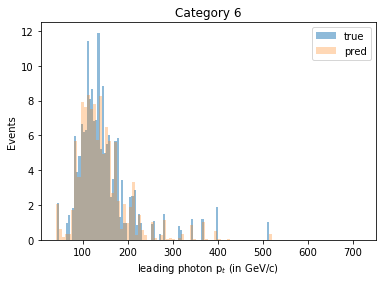

Total number of event in pred hist:  96.9153
Total number of event in true hist:  140.462


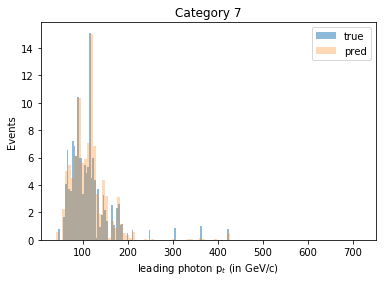

Total number of event in pred hist:  37.6227
Total number of event in true hist:  23.1405


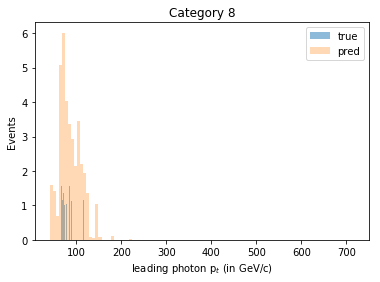

Total number of event in pred hist:  66.1466
Total number of event in true hist:  72.1242


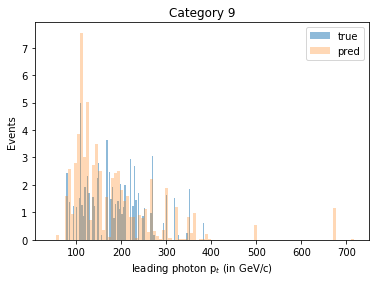

Total number of event in pred hist:  198.308
Total number of event in true hist:  279.271


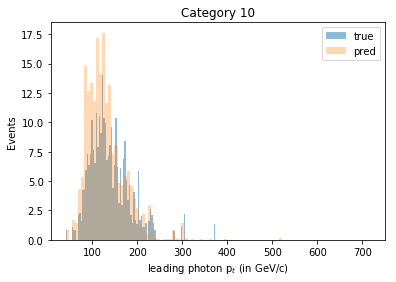

Total number of event in pred hist:  125.067
Total number of event in true hist:  141.759


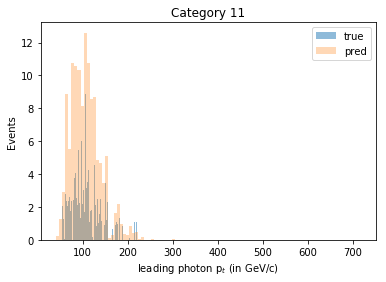

Total number of event in pred hist:  42.4211
Total number of event in true hist:  15.9082


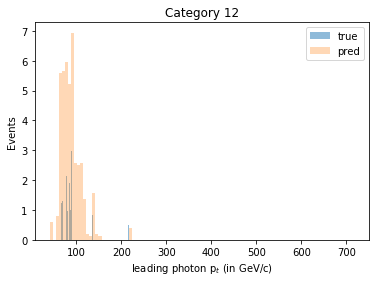

In [18]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(cat_true['leadPho_pt'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(df['leadPho_pt'].ravel(),weights=y_pred_weight[i].ravel(),bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(cat_true['leadPho_pt'].ravel(),weights=cat_true.w_true,bins=100)
    h_pred=np.histogram(df['leadPho_pt'].ravel(),weights=y_pred_weight[i].ravel(),bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("leading photon p$_t$ (in GeV/c)")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()

Total number of event in pred hist:  554.925
Total number of event in true hist:  353.729


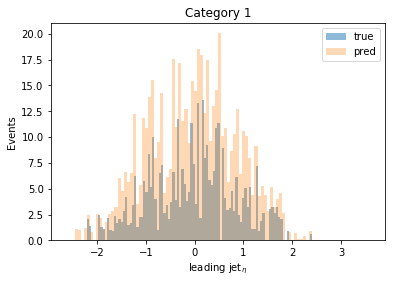

Total number of event in pred hist:  549.023
Total number of event in true hist:  561.792


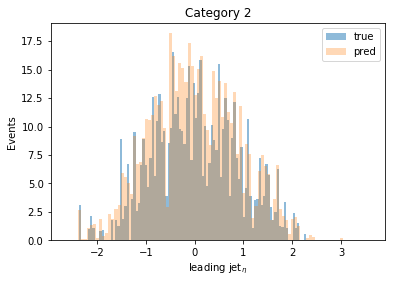

Total number of event in pred hist:  147.683
Total number of event in true hist:  139.795


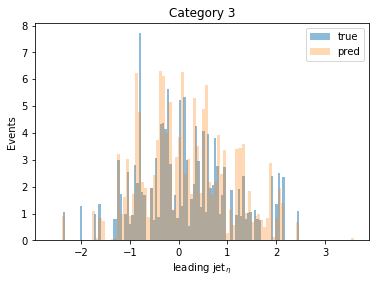

Total number of event in pred hist:  16.0291
Total number of event in true hist:  8.84508


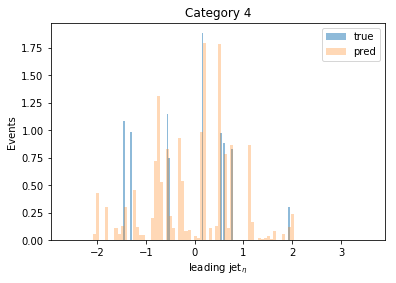

Total number of event in pred hist:  52.8673
Total number of event in true hist:  92.6523


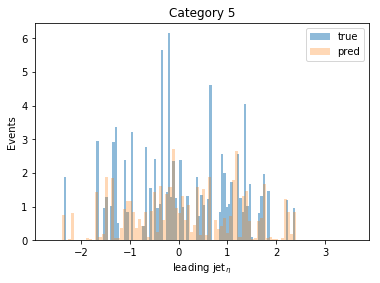

Total number of event in pred hist:  112.882
Total number of event in true hist:  170.412


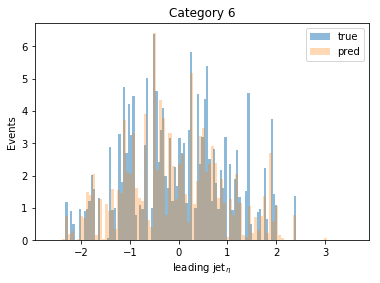

Total number of event in pred hist:  96.9153
Total number of event in true hist:  140.462


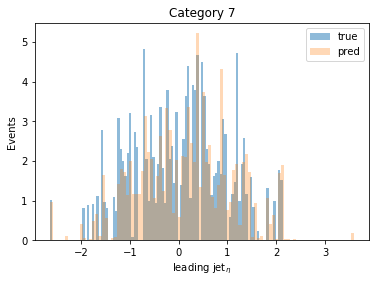

Total number of event in pred hist:  37.6227
Total number of event in true hist:  23.1405


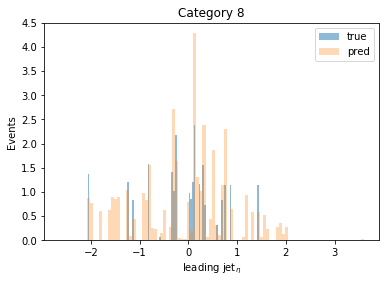

Total number of event in pred hist:  66.1466
Total number of event in true hist:  72.1242


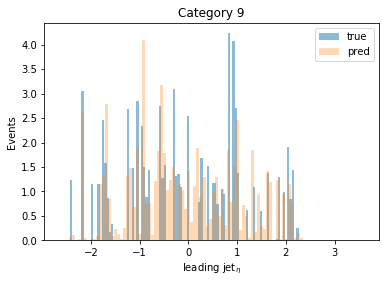

Total number of event in pred hist:  198.308
Total number of event in true hist:  279.271


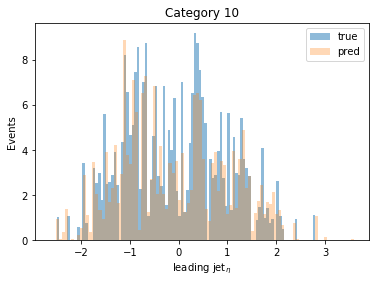

Total number of event in pred hist:  125.067
Total number of event in true hist:  141.759


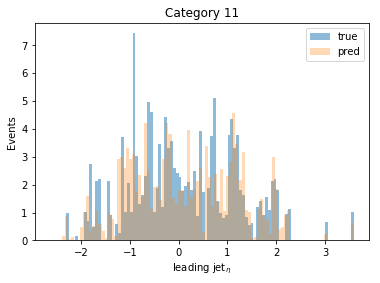

Total number of event in pred hist:  42.4211
Total number of event in true hist:  15.9082


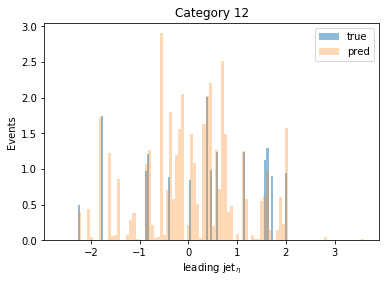

In [19]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(cat_true['leadJet_eta'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(df['leadJet_eta'].ravel(),weights=y_pred_weight[i].ravel(),bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(cat_true['leadJet_eta'].ravel(),weights=cat_true.w_true,bins=100)
    h_pred=np.histogram(df['leadJet_eta'].ravel(),weights=y_pred_weight[i].ravel(),bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("leading jet$_{\eta}$")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()

Total number of event in pred hist:  554.925
Total number of event in true hist:  353.729


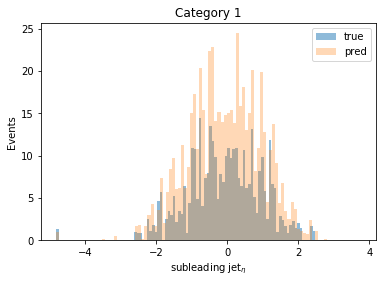

Total number of event in pred hist:  549.023
Total number of event in true hist:  561.792


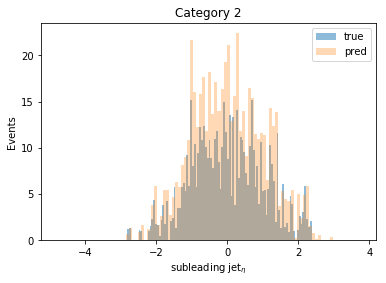

Total number of event in pred hist:  147.683
Total number of event in true hist:  139.795


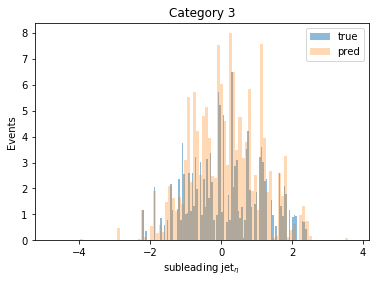

Total number of event in pred hist:  16.0291
Total number of event in true hist:  8.84509


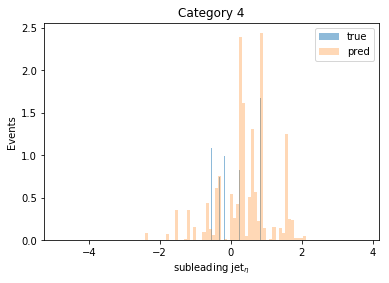

Total number of event in pred hist:  52.8673
Total number of event in true hist:  92.6523


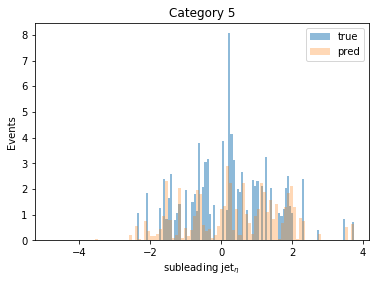

Total number of event in pred hist:  112.882
Total number of event in true hist:  170.412


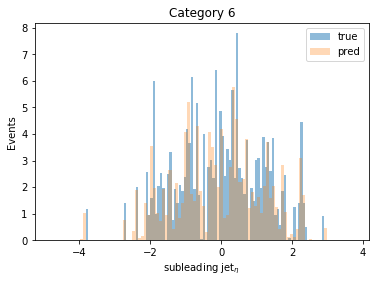

Total number of event in pred hist:  96.9153
Total number of event in true hist:  140.462


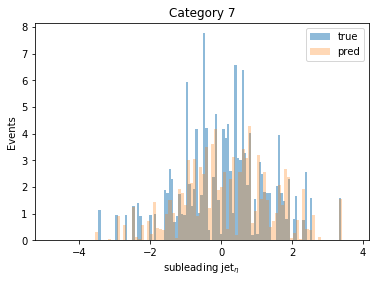

Total number of event in pred hist:  37.6227
Total number of event in true hist:  23.1405


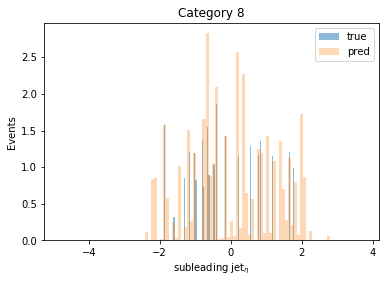

Total number of event in pred hist:  66.1466
Total number of event in true hist:  72.1242


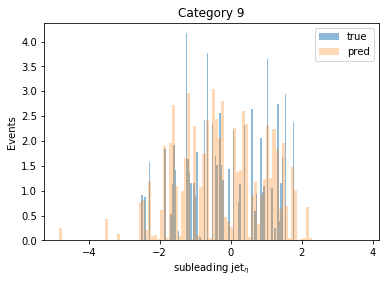

Total number of event in pred hist:  198.308
Total number of event in true hist:  279.271


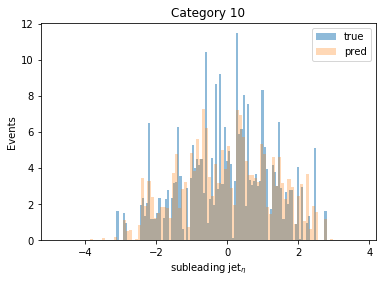

Total number of event in pred hist:  125.067
Total number of event in true hist:  141.759


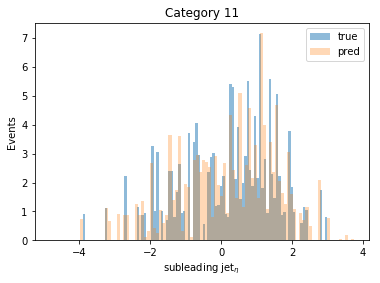

Total number of event in pred hist:  42.4211
Total number of event in true hist:  15.9082


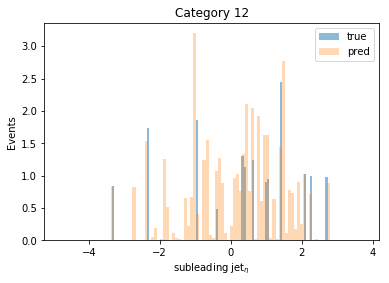

In [20]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(cat_true['subleadJet_eta'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(df['subleadJet_eta'].ravel(),weights=y_pred_weight[i].ravel(),bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(cat_true['subleadJet_eta'].ravel(),weights=cat_true.w_true,bins=100)
    h_pred=np.histogram(df['subleadJet_eta'].ravel(),weights=y_pred_weight[i].ravel(),bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("subleading jet$_{\eta}$")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()

Total number of event in pred hist:  554.925
Total number of event in true hist:  353.729


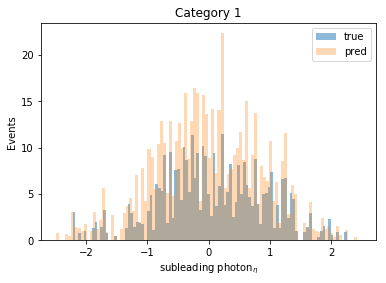

Total number of event in pred hist:  549.023
Total number of event in true hist:  561.792


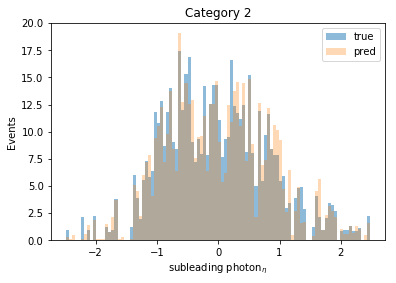

Total number of event in pred hist:  147.683
Total number of event in true hist:  139.795


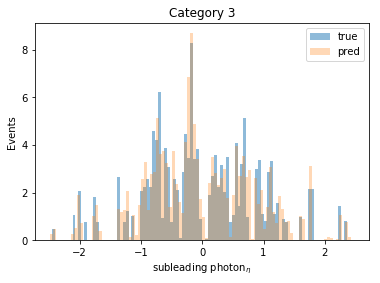

Total number of event in pred hist:  16.0291
Total number of event in true hist:  8.84509


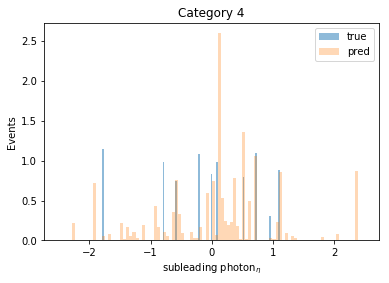

Total number of event in pred hist:  52.8673
Total number of event in true hist:  92.6523


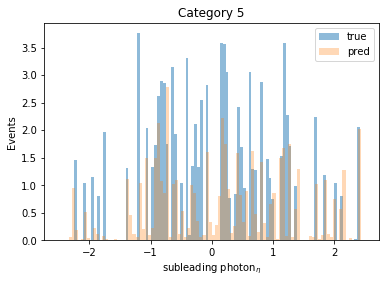

Total number of event in pred hist:  112.882
Total number of event in true hist:  170.412


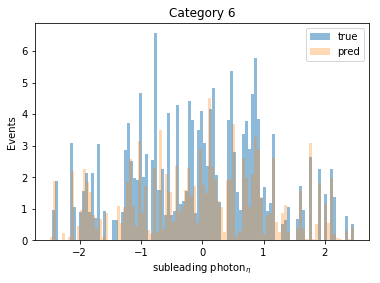

Total number of event in pred hist:  96.9153
Total number of event in true hist:  140.462


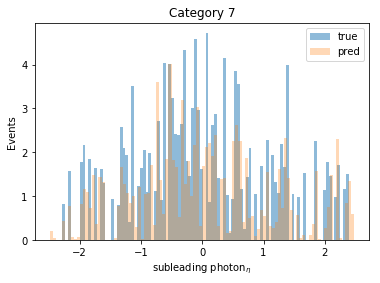

Total number of event in pred hist:  37.6227
Total number of event in true hist:  23.1405


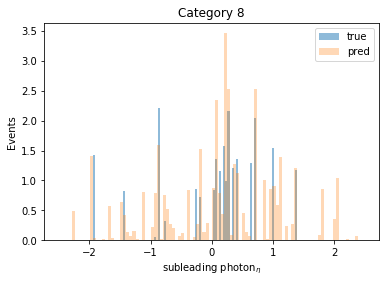

Total number of event in pred hist:  66.1466
Total number of event in true hist:  72.1242


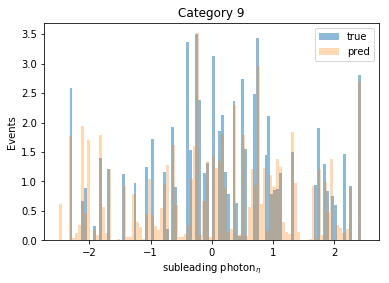

Total number of event in pred hist:  198.308
Total number of event in true hist:  279.271


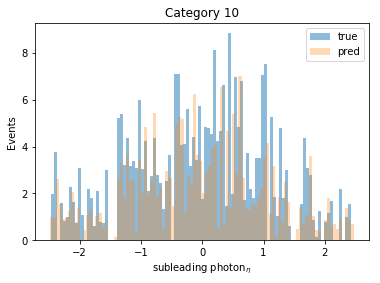

Total number of event in pred hist:  125.067
Total number of event in true hist:  141.759


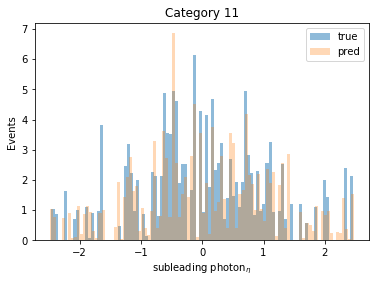

Total number of event in pred hist:  42.4211
Total number of event in true hist:  15.9082


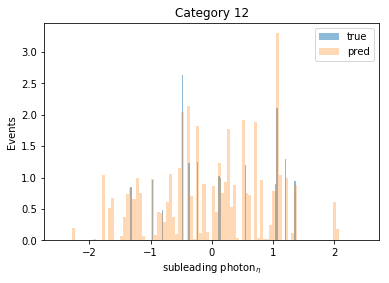

In [21]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(cat_true['subleadPho_eta'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(df['subleadPho_eta'].ravel(),weights=y_pred_weight[i].ravel(),bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(cat_true['subleadPho_eta'].ravel(),weights=cat_true.w_true,bins=100)
    h_pred=np.histogram(df['subleadPho_eta'].ravel(),weights=y_pred_weight[i].ravel(),bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("subleading photon$_{\eta}$")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()

Total number of event in pred hist:  554.925
Total number of event in true hist:  353.729


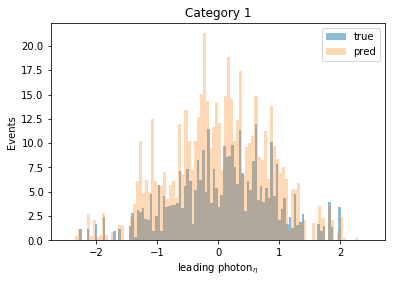

Total number of event in pred hist:  549.023
Total number of event in true hist:  561.792


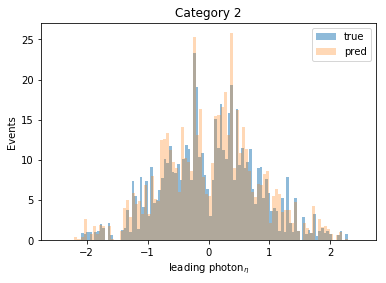

Total number of event in pred hist:  147.683
Total number of event in true hist:  139.795


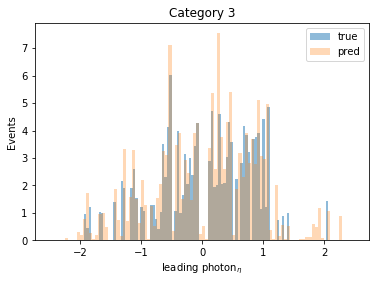

Total number of event in pred hist:  16.0291
Total number of event in true hist:  8.84509


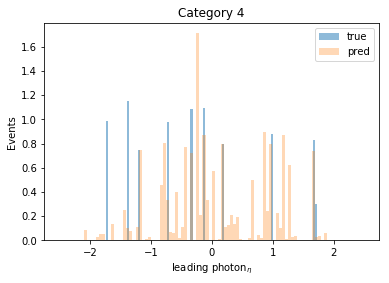

Total number of event in pred hist:  52.8673
Total number of event in true hist:  92.6523


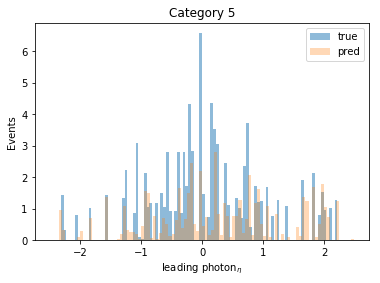

Total number of event in pred hist:  112.882
Total number of event in true hist:  170.412


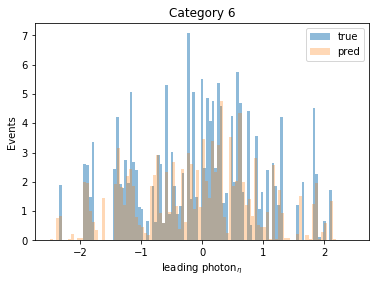

Total number of event in pred hist:  96.9153
Total number of event in true hist:  140.462


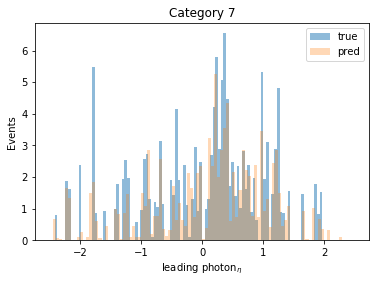

Total number of event in pred hist:  37.6227
Total number of event in true hist:  23.1405


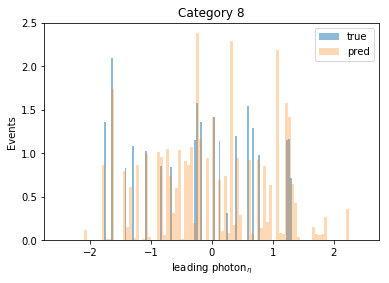

Total number of event in pred hist:  66.1466
Total number of event in true hist:  72.1242


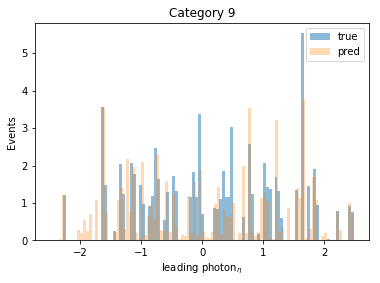

Total number of event in pred hist:  198.308
Total number of event in true hist:  279.271


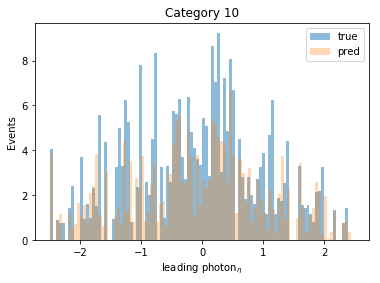

Total number of event in pred hist:  125.067
Total number of event in true hist:  141.759


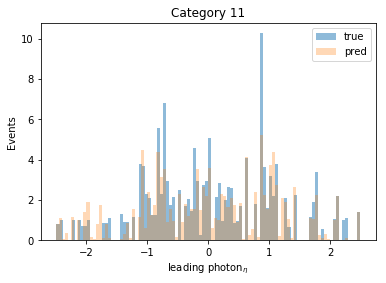

Total number of event in pred hist:  42.4211
Total number of event in true hist:  15.9082


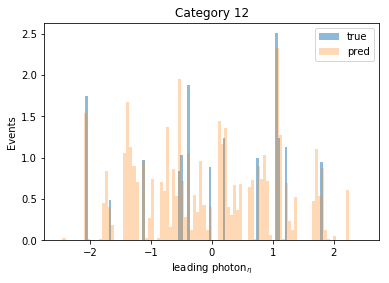

In [22]:
for i in range (0,12):
    cat_true=df[df.cat_true==i+1]
    plt.hist(cat_true['leadPho_eta'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(df['leadPho_eta'].ravel(),weights=y_pred_weight[i].ravel(),bins=100,alpha=0.3,label='pred')
    h_true=np.histogram(cat_true['leadPho_eta'].ravel(),weights=cat_true.w_true,bins=100)
    h_pred=np.histogram(df['leadPho_eta'].ravel(),weights=y_pred_weight[i].ravel(),bins=100)
    print "Total number of event in pred hist: ",np.sum(h_pred[0])
    print "Total number of event in true hist: ",np.sum(h_true[0])
    plt.ylabel("Events")
    plt.xlabel("leading photon$_{\eta}$")
    plt.title('Category %d'%(i+1))
    plt.legend()
    plt.show()
    plt.close()